# Utility

## Imports and Definitions

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from MSC.StrategicModels import StrategicModel
from MSC.SocialMeasures import Utility
from MSC.CommonFunctions import *
import DataGeneration as data

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

matplotlib.rc('font', size=14)

PATH = "./Results/utility"
if not os.path.exists(PATH):
    os.makedirs(PATH)

## Data Loading

In [2]:
# credit dataset
X, Y = data.load_credit_default_data()
X, Y = X[:3000], Y[:3000]
X, Y, Xval, Yval, Xtest, Ytest = data.split_validation_test(X, Y)

## Training

In [3]:
x_dim = len(X[0])
scale = 1 # 1 / x_dim
epochs = 10
batch_size = 64

lambda_range = np.arange(0.05, 1.201, 0.05)
print(lambda_range)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2 ]


In [4]:
init_time = time.time()

results = {
    "lambdas": [],
    "accuracies": [],
    "utilities": []
}

print(f"---------- Training with lambda={0:.3f} ----------")
model_name = f"utility_{0:.3f}"
utility = Utility(0, quad_cost_torch, cost_const_kwargs={"scale": scale})  # Create utility from outside since reg=0.
benchmark_model = StrategicModel(x_dim, batch_size, cost_fn="quad", cost_const_kwargs={"scale": scale}, 
                                 social_measure_dict={"utility": utility}, strategic=True)
benchmark_model.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 5e-2}, epochs=epochs,
                    verbose="batches", path=PATH, model_name=model_name)

results["lambdas"].append(0)
accuracy = benchmark_model.evaluate(Xtest, Ytest, strategic_data=True)
results["accuracies"].append(accuracy)
Xtest_opt, Ytest_pred = benchmark_model.forward(Xtest, requires_grad=False)
utility = benchmark_model.social_measure_dict["utility"].calc_utility(Xtest, Xtest_opt, Ytest_pred, requires_grad=False).item()
results["utilities"].append(utility)
pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

for lamb in lambda_range:
    print(f"---------- Training with lambda={lamb:.3f} ----------")
    model_name = f"utility_{lamb:.3f}"
    model = StrategicModel(x_dim, batch_size, cost_fn="quad", cost_const_kwargs={"scale": scale}, utility_reg=lamb, strategic=True)
    model.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 5e-2}, epochs=epochs,
              verbose="batches", path=PATH, model_name=model_name)
    
    # Calculate and save results.
    results["lambdas"].append(lamb)
    accuracy = model.evaluate(Xtest, Ytest, strategic_data=True)
    results["accuracies"].append(accuracy)
    Xtest_opt, Ytest_pred = model.forward(Xtest, requires_grad=False)
    utility = model.social_measure_dict["utility"].calc_utility(Xtest, Xtest_opt, Ytest_pred, requires_grad=False).item()
    results["utilities"].append(utility)
    pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

final_time = time.time()
total_time = final_time - init_time
print(f"Test took {total_time / 60} minutes ({total_time} seconds).")

---------- Training with lambda=0 ----------
Starting epoch 001 / 010.


C:\Users\technion\.conda\envs\SCMP\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


  batch 001 / 029 | loss: 0.87442 | error: 0.40625 | utility: 0.93142
  batch 002 / 029 | loss: 0.86309 | error: 0.40625 | utility: 0.92997
  batch 003 / 029 | loss: 0.92107 | error: 0.44792 | utility: 0.94154
  batch 004 / 029 | loss: 0.91831 | error: 0.45312 | utility: 0.94454
  batch 005 / 029 | loss: 0.90621 | error: 0.45312 | utility: 0.94243
  batch 006 / 029 | loss: 0.91022 | error: 0.45833 | utility: 0.93526
  batch 007 / 029 | loss: 0.91913 | error: 0.46875 | utility: 0.91787
  batch 008 / 029 | loss: 0.93124 | error: 0.48047 | utility: 0.89706
  batch 009 / 029 | loss: 0.94589 | error: 0.49653 | utility: 0.88326
  batch 010 / 029 | loss: 0.93917 | error: 0.49375 | utility: 0.85926
  batch 011 / 029 | loss: 0.92464 | error: 0.48864 | utility: 0.87629
  batch 012 / 029 | loss: 0.93360 | error: 0.49479 | utility: 0.80194
  batch 013 / 029 | loss: 0.92422 | error: 0.48918 | utility: 0.75488
  batch 014 / 029 | loss: 0.91955 | error: 0.48996 | utility: 0.73737
  batch 015 / 029 | 

## Show Results

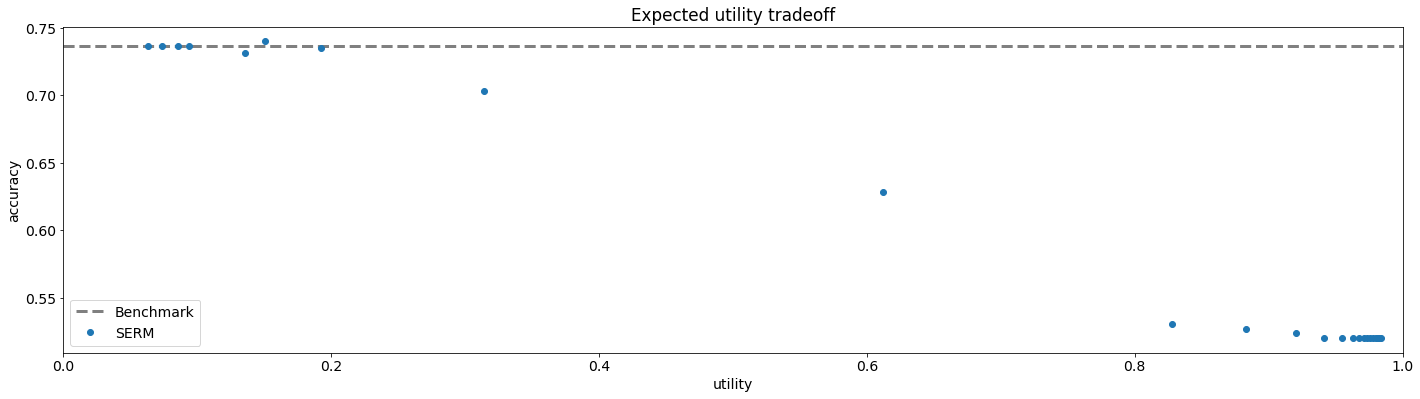

In [5]:
results = pd.read_csv("Results/utility/results.csv")
accuracies = results["accuracies"].to_list()
utilities = results["utilities"].to_list()
benchmark = accuracies[0]

fig, ax = plt.subplots(1, figsize=(24, 6))

_ = ax.set_xlabel("utility")
_ = ax.set_xlim([0, 1])
_ = ax.set_ylabel("accuracy")
_ = ax.set_title("Expected utility tradeoff")
_ = ax.axhline(y=benchmark, linewidth=3, linestyle="--", color="gray", label="Benchmark")
_ = ax.plot(utilities, accuracies, 'o',  label="SERM")
_ = ax.legend()